In [31]:
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import shap
# Load dataset
df = pd.read_csv("mat_health.csv")  # Replace with your actual dataset file

# Handling missing values (optional, remove or impute missing values)
df = df.dropna()

# Encoding categorical features if needed
categorical_cols = ["Previous Complications", "Preexisting Diabetes", "Gestational Diabetes", "Mental Health", "Risk Level"]
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store encoders for decoding predictions later

# Define features and target
X = df.drop(columns=["Risk Level"])  # Features
y = df["Risk Level"]  # Target variable

# Split dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numerical features (recommended for better performance)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)




In [32]:
# Fit model
# Standardize and rewrap with column names
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X.columns)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Use PermutationImportance
perm = PermutationImportance(model, random_state=42).fit(X_test, y_test)

# Show feature importances
eli5.show_weights(perm, feature_names=X.columns.tolist())



Weight,Feature
0.0709 ± 0.0327,Preexisting Diabetes
0.0632 ± 0.0322,Gestational Diabetes
0.0333 ± 0.0126,BMI
0.0197 ± 0.0042,Mental Health
0.0171 ± 0.0153,Heart Rate
0.0145 ± 0.0087,BS
0.0051 ± 0.0064,Diastolic
0.0051 ± 0.0064,Systolic BP
0.0043 ± 0.0000,Previous Complications
0.0017 ± 0.0042,Age


In [43]:
from rulefit import RuleFit

X_train_simple = X_train.copy()
X_train_simple.columns = range(X_train_simple.shape[1])
X_test_simple = X_test.copy()
X_test_simple.columns = range(X_test_simple.shape[1])

feature_names = list(X_train_simple.columns)

rf = RuleFit(tree_size=3, max_rules=500)
rf.fit(X_train_simple, y_train, feature_names=feature_names)

y_pred = rf.predict(X_test_simple)

from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred))

rules = rf.get_rules()
rules = rules[rules.coef != 0].sort_values(by="support", ascending=False)
print(rules[['rule', 'coef', 'support']])


KeyError: (slice(None, None, None), 3)

In [ ]:
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)
ebm_local = ebm.explain_local(X_test[:5], y_test[:5])
show(ebm_local)

<!-- http://127.0.0.1:7001/5476946800/ -->

🔹 Logistic Regression Model
Accuracy: 0.9786
              precision    recall  f1-score   support

           0       0.97      0.98      0.97        86
           1       0.99      0.98      0.98       148

    accuracy                           0.98       234
   macro avg       0.98      0.98      0.98       234
weighted avg       0.98      0.98      0.98       234

------------------------------------------------------------
🔹 Decision Tree Model
Accuracy: 0.9744
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        86
           1       0.98      0.98      0.98       148

    accuracy                           0.97       234
   macro avg       0.97      0.97      0.97       234
weighted avg       0.97      0.97      0.97       234

------------------------------------------------------------
🔹 Random Forest Model
Accuracy: 0.9915
              precision    recall  f1-score   support

           0       0.99      0.99      0.99   

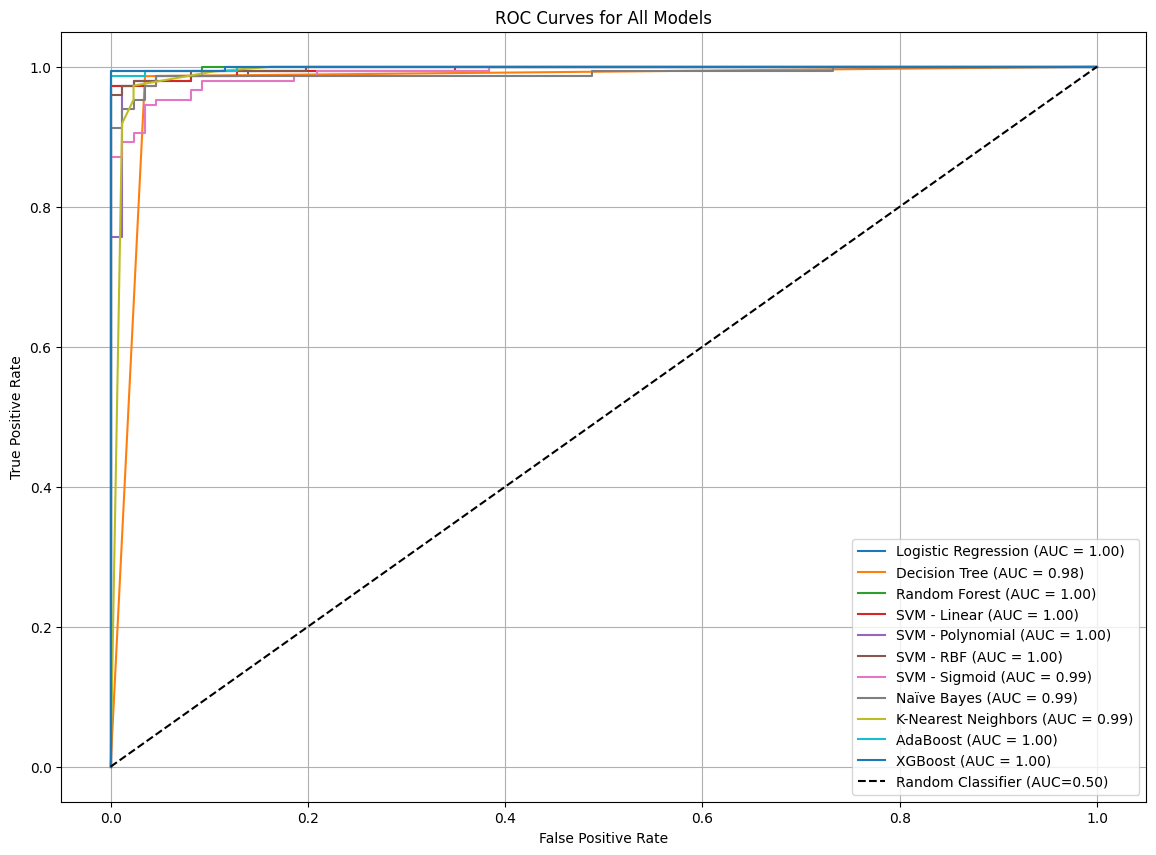

In [ ]:
# Train a Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=150, random_state=42),
    "SVM - Linear": SVC(kernel="linear"),
    "SVM - Polynomial": SVC(kernel="poly", degree=3),
    "SVM - RBF": SVC(kernel="rbf"),
    "SVM - Sigmoid": SVC(kernel="sigmoid"),
    "Naïve Bayes": GaussianNB(),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "AdaBoost": AdaBoostClassifier(n_estimators=100),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss")
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"🔹 {name} Model")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))
    print("-" * 60)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Binarize y_test if it's not already binary (important for ROC)
# Ensure y_train and y_test are properly encoded if needed

plt.figure(figsize=(14, 10))

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Check if model has predict_proba or decision_function
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_test)
    else:
        y_scores = y_pred  # fallback, not ideal for ROC

    # ROC Curve and AUC Score
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    auc_score = roc_auc_score(y_test, y_scores)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.2f})")

    print(f"🔹 {name} Model")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"AUC Score: {auc_score:.4f}")
    print(classification_report(y_test, y_pred))
    print("-" * 60)

# Plot formatting
plt.plot([0, 1], [0, 1], "k--", label="Random Classifier (AUC=0.50)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Models")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [ ]:
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.pipeline import make_pipeline

# ---------- 1. Stacking ----------
stack_estimators = [
    ("rf", RandomForestClassifier(n_estimators=150, random_state=42)),
    ("svc", SVC(kernel="rbf", probability=True)),
    ("xgb", XGBClassifier(use_label_encoder=False, eval_metric="logloss"))
]

stacking = StackingClassifier(
    estimators=stack_estimators,
    final_estimator=LogisticRegression(max_iter=1000),
    passthrough=True         # keep original features alongside meta‑features
)
stacking.fit(X_train, y_train)
y_pred_stack = stacking.predict(X_test)
print("🔹 Stacking")
print("Accuracy:", accuracy_score(y_test, y_pred_stack))
print(classification_report(y_test, y_pred_stack))
print("-"*60)

# ---------- 2. Voting – Hard ----------
hard_voting = VotingClassifier(
    estimators=[
        ("rf", models["Random Forest"]),
        ("svc", models["SVM - RBF"]),
        ("knn", models["K-Nearest Neighbors"])
    ],
    voting="hard"
)
hard_voting.fit(X_train, y_train)
y_pred_hard = hard_voting.predict(X_test)
print("🔹 Hard Voting")
print("Accuracy:", accuracy_score(y_test, y_pred_hard))
print(classification_report(y_test, y_pred_hard))
print("-"*60)

# ---------- 3. Voting – Soft ----------
soft_voting = VotingClassifier(
    estimators=[
        ("rf", RandomForestClassifier(n_estimators=150, random_state=42)),
        ("svc", SVC(kernel="rbf", probability=True)),   # probability=True required
        ("xgb", XGBClassifier(use_label_encoder=False, eval_metric="logloss"))
    ],
    voting="soft",           # average predicted class‑probabilities
    weights=[2, 1, 2]        # optional: favour stronger base models
)
soft_voting.fit(X_train, y_train)
y_pred_soft = soft_voting.predict(X_test)
print("🔹 Soft Voting")
print("Accuracy:", accuracy_score(y_test, y_pred_soft))
print(classification_report(y_test, y_pred_soft))
print("-"*60)


AttributeError: 'super' object has no attribute '__sklearn_tags__'

🔹 Logistic Regression Model
Average Precision Score: 0.9979
------------------------------------------------------------
🔹 Decision Tree Model
Average Precision Score: 0.9777
------------------------------------------------------------
🔹 Random Forest Model
Average Precision Score: 0.9997
------------------------------------------------------------
🔹 SVM - Linear Model
Average Precision Score: 0.9979
------------------------------------------------------------
🔹 SVM - Polynomial Model
Average Precision Score: 0.9970
------------------------------------------------------------
🔹 SVM - RBF Model
Average Precision Score: 0.9986
------------------------------------------------------------
🔹 SVM - Sigmoid Model
Average Precision Score: 0.9946
------------------------------------------------------------
🔹 Naïve Bayes Model
Average Precision Score: 0.9953
------------------------------------------------------------
🔹 K-Nearest Neighbors Model
Average Precision Score: 0.9908
------------------

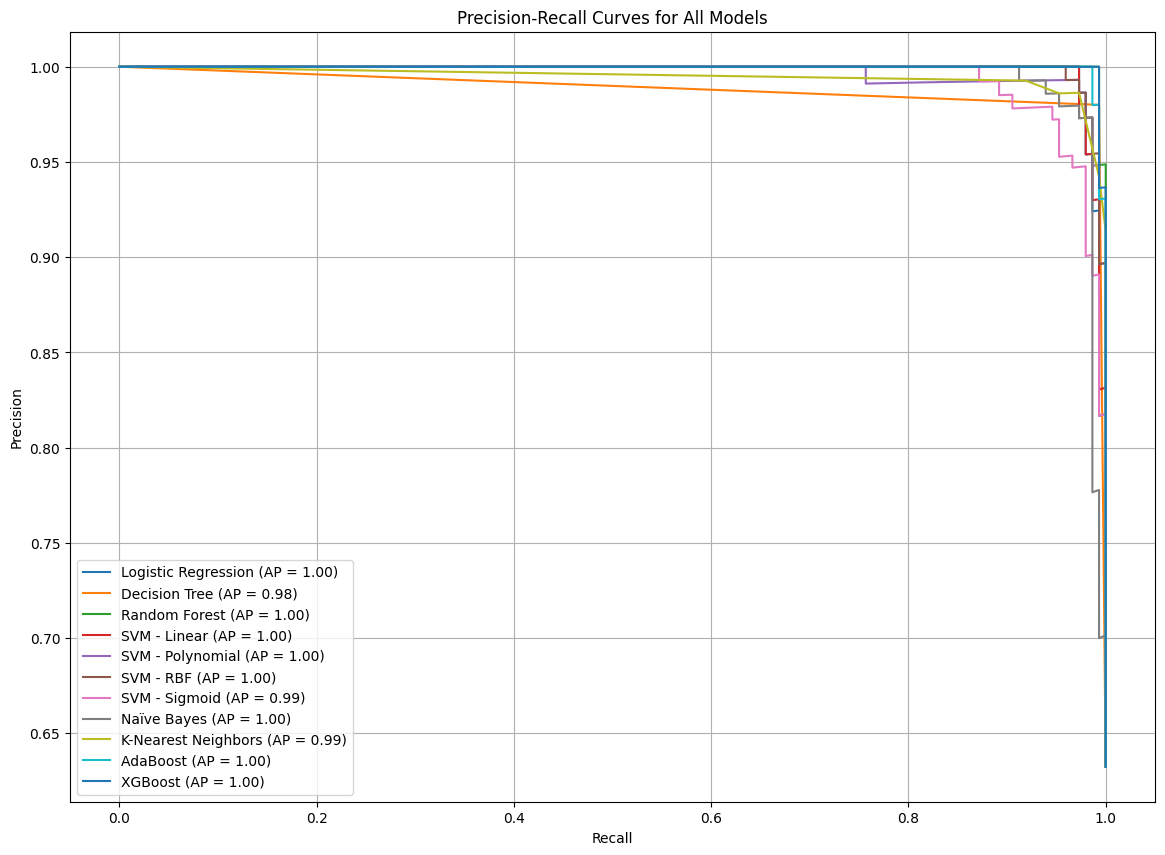

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(14, 10))

for name, model in models.items():
    model.fit(X_train, y_train)

    # Get prediction scores for PR curve
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_test)
    else:
        y_scores = y_test  # fallback

    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    avg_precision = average_precision_score(y_test, y_scores)

    plt.plot(recall, precision, label=f"{name} (AP = {avg_precision:.2f})")

    print(f"🔹 {name} Model")
    print(f"Average Precision Score: {avg_precision:.4f}")
    print("-" * 60)

# Plot formatting
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves for All Models")
plt.legend(loc="lower left")
plt.grid()
plt.show()


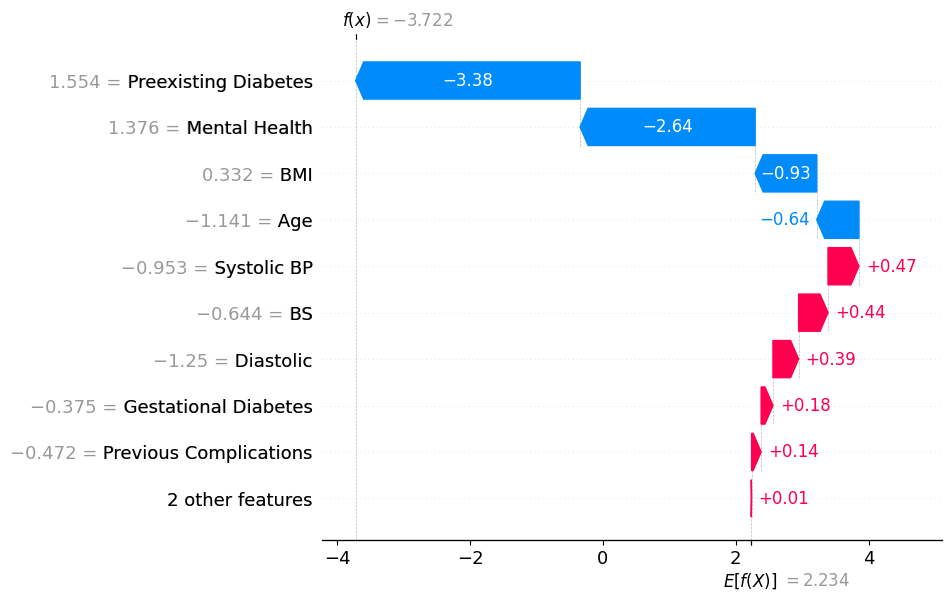

In [ ]:
import shap
import pandas as pd

feature_names = [
    "Age", "Systolic BP", "Diastolic", "BS", "Body Temp", "BMI",
    "Previous Complications", "Preexisting Diabetes", "Gestational Diabetes",
    "Mental Health", "Heart Rate"
]

X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)


# Choose one tree-based model (like XGBoost)
import shap
from xgboost import XGBClassifier

# Train your model (or reuse existing one)
model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
model.fit(X_train, y_train)

# SHAP Explainer
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Choose an instance
instance_index = 0
instance = X_test.iloc[instance_index]

# Waterfall Plot
shap.plots.waterfall(shap_values[instance_index])

# Force Plot (interactive, best in Jupyter)
shap.plots.force(shap_values[instance_index])



In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

# Define your feature names in the correct order
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)
feature_names = [
    "Age", "Systolic BP", "Diastolic", "BS", "Body Temp", "BMI",
    "Previous Complications", "Preexisting Diabetes", "Gestational Diabetes",
    "Mental Health", "Heart Rate"
]

perm = PermutationImportance(model, random_state=42).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=feature_names)
eli5.show_weights(perm, feature_names=X.columns.tolist())



ValueError: feature_names has a wrong length: expected=12, got=11

In [ ]:
import shap
from xgboost import XGBClassifier
import pandas as pd

# Feature names
feature_names = [
    "Age", "Systolic BP", "Diastolic", "BS", "Body Temp", "BMI",
    "Previous Complications", "Preexisting Diabetes", "Gestational Diabetes",
    "Mental Health", "Heart Rate", "Risk Level"
]

# Wrap the feature arrays into DataFrames if not already
X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)

# Train the model (if not already trained)
model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
model.fit(X_train, y_train)

# Create the SHAP Explainer
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Choose a test instance to explain
instance_index = 0  # change index as needed

# Initialize JS for interactive force plot
shap.initjs()

# Display force plot
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values[instance_index].values,
    features=X_test.iloc[instance_index],
    feature_names=X_test.columns
)


In [ ]:
!pip3 install feyn

error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try brew install
    xyz, where xyz is the package you are trying to
    install.
    
    If you wish to install a Python library that isn't in Homebrew,
    use a virtual environment:
    
    python3 -m venv path/to/venv
    source path/to/venv/bin/activate
    python3 -m pip install xyz
    
    If you wish to install a Python application that isn't in Homebrew,
    it may be easiest to use 'pipx install xyz', which will manage a
    virtual environment for you. You can install pipx with
    
    brew install pipx
    
    You may restore the old behavior of pip by passing
    the '--break-system-packages' flag to pip, or by adding
    'break-system-packages = true' to your pip.conf file. The latter
    will permanently disable this error.
    
    If you disable this error, we STRONGLY recommend that you additionally
    pass the '--user' flag to pip, or set 

  0%|          | 0/20 [00:00<?, ?it/s]

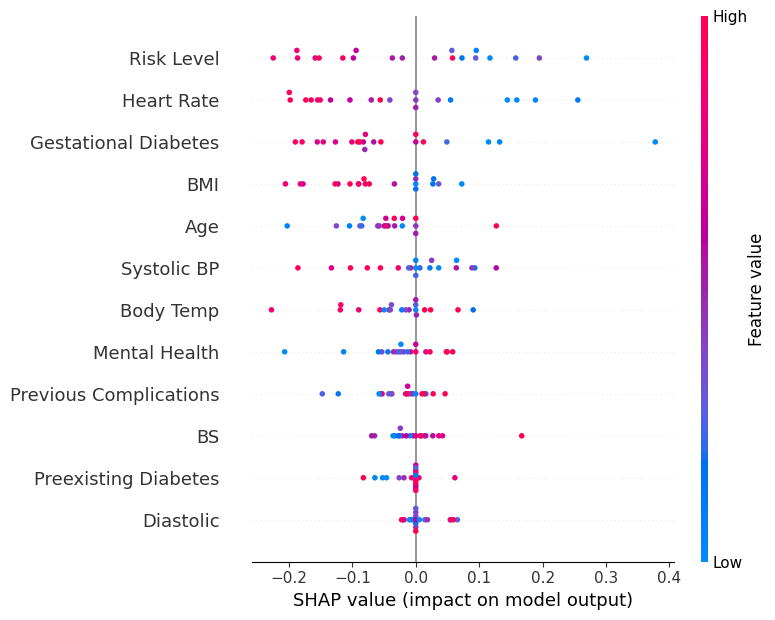

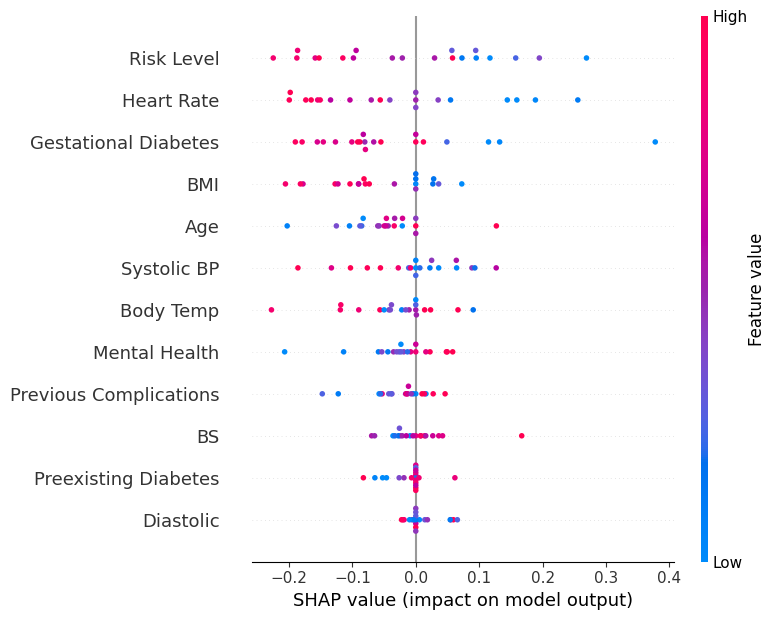

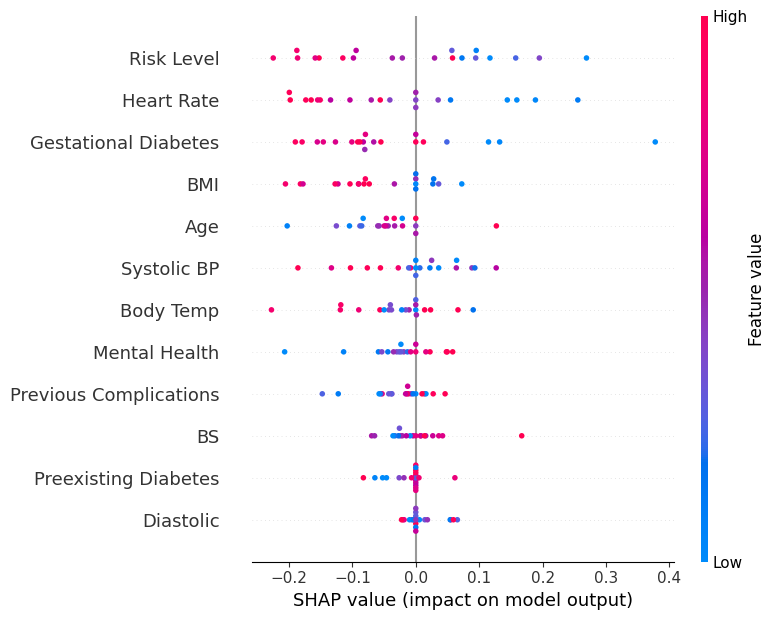

TypeError: 'float' object is not subscriptable

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Select the best-performing model (Random Forest in this case)
best_model = models["Random Forest"]

# # Create a SHAP explainer
# explainer = shap.TreeExplainer(best_model)

# # Compute SHAP values for test data
# shap_values = explainer.shap_values(X_test)
# explainer = shap.TreeExplainer(best_model)
# shap_values = explainer.shap_values(X_test).values
explainer = shap.KernelExplainer(best_model.predict, X_train[:50])  # Use a small sample
shap_values = explainer.shap_values(X_test[:50])  # Compute for a small batch

# Plot summary
shap.summary_plot(shap_values, X_test[:50], feature_names=X.columns)

# Ensure the correct class is selected (for multi-class models)
if isinstance(shap_values, list):  
    shap_values = shap_values[1]
    print("SHAP values shape:", np.shape(shap_values))
    print("X_test shape:", np.shape(X_test))
  # Select SHAP values for class 1

# Plot summary
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

# Summary plot: Shows overall feature importance
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, feature_names=X.columns)
plt.show()

# Individual force plot for the first test sample
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], X_test[0], matplotlib=True)


Feature Importance in Random Forest:
                   Feature  Importance
8     Gestational Diabetes    0.122173
11              Risk Level    0.111347
10              Heart Rate    0.092547
0                      Age    0.091706
6   Previous Complications    0.079841
9            Mental Health    0.079513
4                Body Temp    0.078088
2                Diastolic    0.073980
5                      BMI    0.072393
7     Preexisting Diabetes    0.071491
3                       BS    0.063675
1              Systolic BP    0.063246


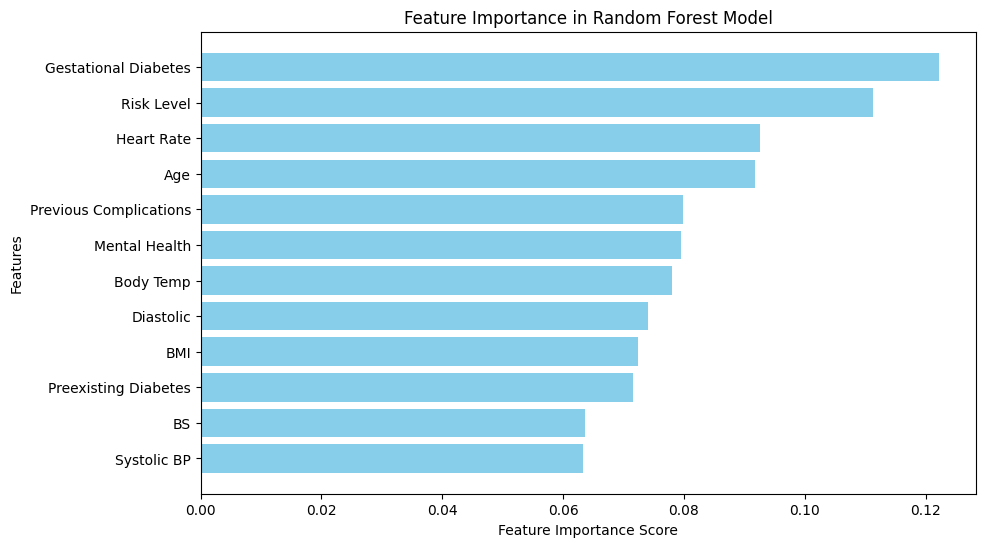

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure X_train is a DataFrame
feature_names = X.columns if isinstance(X, pd.DataFrame) else [f"Feature {i}" for i in range(X_train.shape[1])]

# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=150, random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importance
feature_importance = rf_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print feature importance
print("Feature Importance in Random Forest:")
print(feature_importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest Model")
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.show()


In [ ]:
import lime
import lime.lime_tabular
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define feature names as per the given order
feature_names = [
    "Age", "Systolic BP", "Diastolic", "BS", "Body Temp", "BMI", 
    "Previous Complications", "Preexisting Diabetes", "Gestational Diabetes", 
    "Mental Health", "Heart Rate", "Risk Level"
]

# Generate synthetic data (replace with actual dataset)
X = np.random.rand(100, len(feature_names))  # 100 samples, 12 features
y = np.random.randint(0, 2, 100)  # Binary classification

# Convert to DataFrame with named columns
X = pd.DataFrame(X, columns=feature_names)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define model
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Train model
models["Random Forest"].fit(X_train, y_train)

# LIME Explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=feature_names,
    class_names=['Low Risk', 'High Risk'],  # Adjust as per your classification
    mode='classification'
)

# Explain a prediction
i = 0  # Choose a test sample index
exp = explainer.explain_instance(X_test.iloc[i], models["Random Forest"].predict_proba)
exp.show_in_notebook()  # For Jupyter Notebook


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, inte

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
# Train EBM model
ebm = ExplainableBoostingClassifier(random_state=42)
ebm.fit(X_train, y_train)

# 📌 Local explanation for first 5 test samples
ebm_local = ebm.explain_local(X_test[:5], y_test[:5])
show(ebm_local)

# 🌐 Global explanation (overall feature importance & effects)
ebm_global = ebm.explain_global()
show(ebm_global)


<!-- http://127.0.0.1:7001/6072348624/ -->

<!-- http://127.0.0.1:7001/6072993840/ -->

InvalidIndexError: (slice(None, None, None), 1)